# Programming Exercise 2: Logistic Regression
可以在 sklearn 中调用 LogisticRegression 快速实现

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data1 = pd.read_csv('data/ex2data1.txt', header=None, names='x1 x2 y'.split())
data2 = pd.read_csv('data/ex2data2.txt', header=None, names='x1 x2 y'.split())
data1.head()

,x1,x2,y
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


# 1.1 Visualizing the data

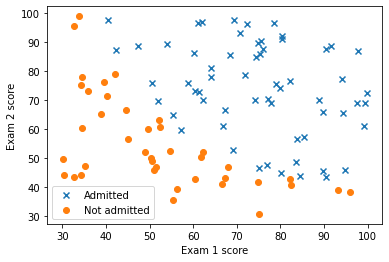

In [2]:
def plot_data(data, xlabel='Exam 1 score', ylabel='Exam 2 score', scatter_labels=['Admitted', 'Not admitted']):
    positive = data[data['y'] == 1]
    negative = data[data['y'] == 0]
    
    plt.scatter(positive['x1'], positive['x2'], marker='x', label=scatter_labels[0])
    plt.scatter(negative['x1'], negative['x2'], marker='o', label=scatter_labels[1])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    plt.show()

plot_data(data1)

# 1.2 Implementation

In [3]:
y = data1.iloc[:, -1].values
X = np.concatenate((np.ones(len(y))[:, None], data1.iloc[:, :-1].values), axis=1) # add the ones to the left
X.shape, y.shape

((100, 3), (100,))

In [4]:
def sigmoid(z):
    return 1 / (1 + np.e ** (-z))

def hypothesis(theta, z):
    return sigmoid(z @ theta)

def cost_function(theta, X, y):
    return (-y * np.log(hypothesis(theta, X)) - (1 - y) * np.log(1 - hypothesis(theta, X))).mean()

cost_function(np.zeros(3), X, y)

0.6931471805599453

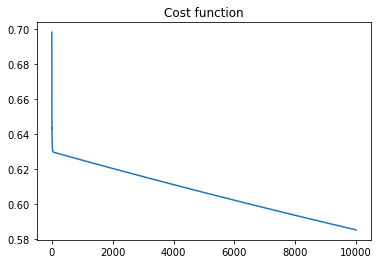

In [5]:
def gradient(theta, X, y):
    m = len(y)
    return 1 / m * X.T @ (hypothesis(theta, X) - y)

def gradient_descent(X, y, theta, alpha, iterations, costs):
    for n in range(iterations):
        theta -= alpha * gradient(theta, X, y)
        costs.append(cost_function(theta, X, y))

    plt.plot(costs)
    plt.title('Cost function')
    plt.show()

theta = np.zeros(3)
costs = []
gradient_descent(X, y, theta, alpha=0.001, iterations=10000, costs=costs)

自己测试 GD，发现效果不好，100000 次循环也学不到收敛，探索一下其他方法

<ipython-input-4-6dade02a3794>:8: RuntimeWarning: divide by zero encountered in log
  return (-y * np.log(hypothesis(theta, X)) - (1 - y) * np.log(1 - hypothesis(theta, X))).mean()
<ipython-input-4-6dade02a3794>:8: RuntimeWarning: invalid value encountered in multiply
  return (-y * np.log(hypothesis(theta, X)) - (1 - y) * np.log(1 - hypothesis(theta, X))).mean()


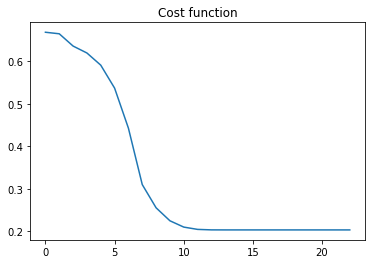

      fun: 0.20349770158944383
 hess_inv: array([[ 3.31474479e+03, -2.63892205e+01, -2.70237122e+01],
       [-2.63892205e+01,  2.23869433e-01,  2.02682332e-01],
       [-2.70237122e+01,  2.02682332e-01,  2.35335117e-01]])
      jac: array([-9.52476805e-09, -9.31921308e-07, -2.82608920e-07])
  message: 'Optimization terminated successfully.'
     nfev: 31
      nit: 23
     njev: 31
   status: 0
  success: True
        x: array([-25.16133284,   0.2062317 ,   0.2014716 ])

In [6]:
from scipy.optimize import minimize

costs2 = []
def callback(xk):
    costs2.append(cost_function(xk, X, y))

result = minimize(cost_function, np.zeros(3), (X, y), method='BFGS', jac=gradient, callback=callback)
plt.plot(costs2)
plt.title('Cost function')
plt.show()
result

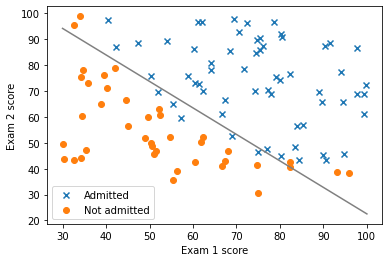

In [7]:
theta = result.x
x1_plot = np.linspace(30, 100, 5)
x2_plot = -(theta[0] + theta[1] * x1_plot) / theta[2]

plt.plot(x1_plot, x2_plot, 'gray') # decision boundary
plot_data(data1)

# 2 Regularized logistic regression

# 2.1 Visualizing the data

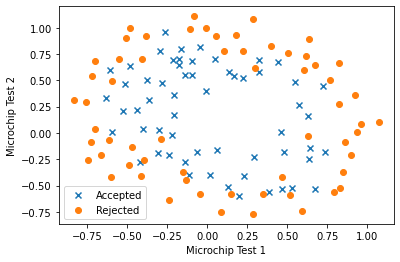

In [8]:
plot_data(data2, xlabel='Microchip Test 1', ylabel='Microchip Test 2', scatter_labels=['Accepted', 'Rejected'])

# 2.2 Feature mapping

In [9]:
y = data2.iloc[:, -1].values
X = np.concatenate((np.ones(len(y))[:, None], data2.iloc[:, :-1].values), axis=1) # add the ones to the left
X.shape, y.shape

((118, 3), (118,))

In [10]:
POWER = 6

def map_feature(x1, x2, power):
    try:
        x1 = x1[:, None]
        x2 = x2[:, None]
    except:
        x1 = np.array([x1])[:, None]
        x2 = np.array([x2])[:, None]

    result = np.ones((len(x1), 1))
    
    for p in range(1, power + 1):
        for q in range(p + 1):
            result = np.concatenate((result, x2 ** q * x1 ** (p - q)), axis=1)
    return result
    
x1 = X[:, 1]
x2 = X[:, 2]
X_reg = map_feature(x1, x2, power=POWER)
X_reg.shape, y.shape

((118, 28), (118,))

# 2.3 Cost function and gradient

In [11]:
def cost_function_reg(theta, X, y, lam):
    m = len(y)
    return (-y * np.log(hypothesis(theta, X)) - (1 - y) * np.log(1 - hypothesis(theta, X))).mean() + lam / 2 / m * sum(theta[j] ** 2 for j in range(1, len(theta)))

def gradient_reg(theta, X, y, lam):
    m = len(y)
    zero = (X[:, 0] * (hypothesis(theta, X) - y)).mean()
    others = [(X[:, j] * (hypothesis(theta, X) - y)).mean() + lam / m * theta[j]
              for j in range(1, len(theta))]
    return np.array([zero] + others)

由于高次式和低次式的数值差异太大了，用下面的这个方法也实在是学习不出来，最后发现标准化一下马上就解决了。后面发现我在用第一题的数据训练第二题……
实在是有点无语，但是这个标准化的方法好歹成功了一次。

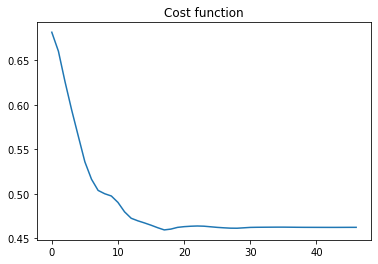

In [17]:
from scipy.optimize import minimize
LAM = 1

def learning():
    costs = []
    def callback_reg(xk):
        costs.append(cost_function_reg(xk, X_reg, y))
    result = minimize(cost_function_reg, np.zeros(X_reg.shape[1]), (X_reg, y, LAM), method='BFGS', jac=gradient_reg, callback=callback_reg)
    plt.plot(costs)
    plt.title('Cost function')
    plt.show()
    return result.x

theta = learning()

# 2.4 Plotting the decision boundary

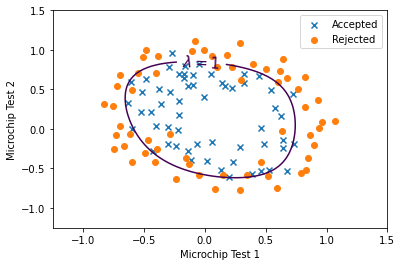

In [18]:
def plotting(theta):
    pt = 100

    x1_plot = np.linspace(-1.25, 1.5, pt)
    x2_plot = np.linspace(-1.25, 1.5, pt - 10)

    xm1, xm2 = np.meshgrid(x1_plot, x2_plot)
    spam = [map_feature(xm1.flatten()[i], xm2.flatten()[i], POWER) for i in range(xm1.shape[0] * xm1.shape[1])]
    zm = np.array([sp @ theta for sp in spam]).reshape(xm1.shape)

    ct = plt.contour(xm1, xm2, zm, levels=[0]) # sigmoid = 0.5 is the decision boundary
    plt.clabel(ct, inline=1, fontsize=15, fmt=r'$\lambda = {}$'.format(LAM))
    plot_data(data2, xlabel='Microchip Test 1', ylabel='Microchip Test 2', scatter_labels=['Accepted', 'Rejected'])

plotting(theta)

# 2.5 Optional (ungraded) exercises

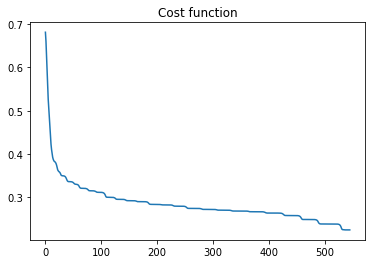

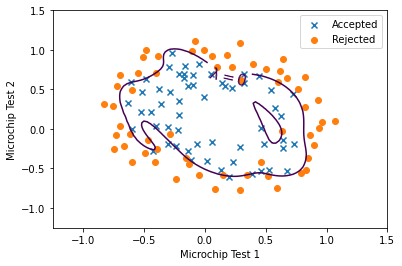

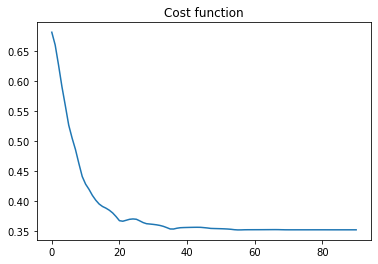

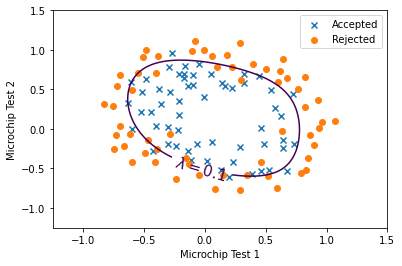

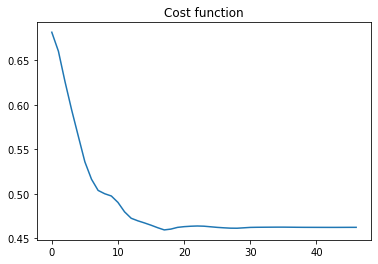

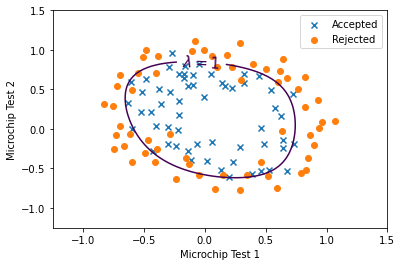

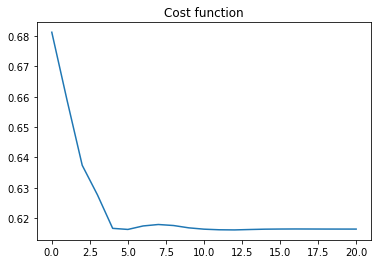

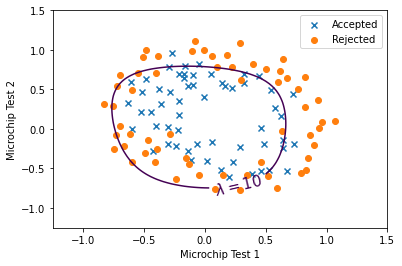

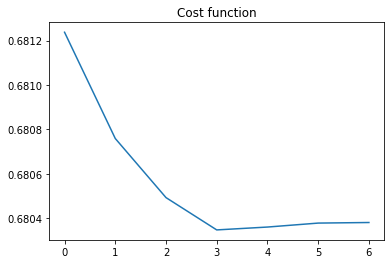

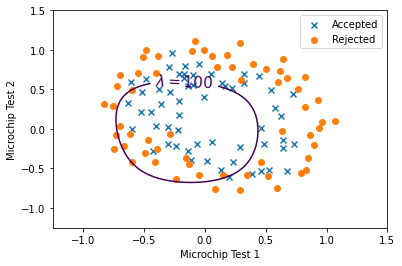

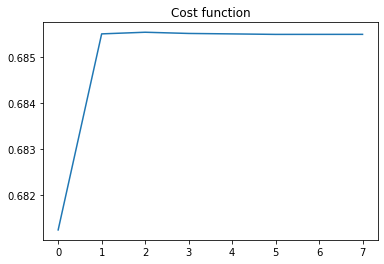

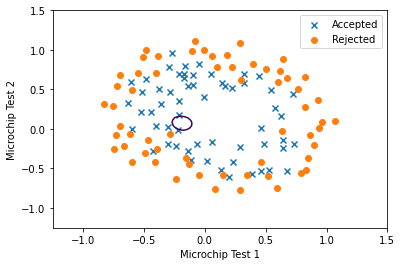

In [16]:
for LAM in [0, 0.1, 1, 10, 100, 175]:
    theta = learning()
    plotting(theta)

做了一整天，总算做完了，进步很大，前路漫漫，加油！